<a href="https://colab.research.google.com/github/neginsh/Deep-Learning-und-Textanalyse-in-Finance/blob/main/Project_Assignment_1_NeginShademan_109731.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Deadline: 21.12.2022 2pm (14:00)

Tasks:


1.   Send an email with your Name and user-id to lukas.marx@uni-passau.de afterwards you will receive your personal dataset for this assignment.
2.   Import the three datasets (training, validation and test) into a google colab and analyze your given data set. Your target variable will be "discr_r".
3.   Generate a Linear Regression model as a benchmark and evaluate it (for comparison the mean absolute error as a performance metric is suggested). 
4.   Generate a neural network with an arbitrary choice of hyperparameters in order to perform a comparable task to the linear regression model and evaluate it. 
5.   Compare the feature importance for the benchmark and the baseline neural network.
6.   Perform hyperparameter tuning with Optuna in order to generate a better performing neural network. 
7.   Evaluate its results and compare them as well as the feature importance to the benchmark and the baseline neural network. 
8.   Describe your results for all three models and explain what your results means with respect to $(R_{Mt} - R_{ft})$ , SMB and HML.
9.   Hand in your single colab Notebook to lukas.marx@uni-passau.de until the above mentioned deadline. 



Negin Shademan

Matrikelnummer:
109731


---



# introduction

In this assignment, we aim to predict discr_r based on the book to market ratio, market capitalization, and beta. In order to solve our prediction problem, a linear regression model and a neural network have been trained. We will use the linear regression model as a benchmark and compare the neural network to it in order to evaluate its performance.




# Loading the dataset

Python is a fantastic language with many amazing libraries that help programmers tackle any problem. First, the required modules should be imported. After loading the necessary modules, we need to load the datasets. 

In [ ]:
# imports
!pip install optuna

import numpy as np
import pandas as pd
import pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt
import scipy.stats as scs
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, r2_score, mean_absolute_error as mae
from sklearn.linear_model import LinearRegression
from pydotplus import graph_from_dot_data
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.cluster import homogeneity_score 

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.models import Sequential 
from keras.layers import Dense 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/train_data-7.csv')
validation = pd.read_csv('/content/drive/MyDrive/validation_data-7.csv')
test = pd.read_csv('/content/drive/MyDrive/test_data-8.csv')

# Analysis of dataset



First of all, we need to understand our features.




*   The **book-to-market ratio** is a measure of a company's value, which is determined by comparing the firm's book value to its market value. The book value is determined by evaluating the company's historical cost, or accounting value. The market value is determined by the firm's share price in the stock market and the number of shares it has outstanding, which is its market capitalization. This ratio provides insight into the company's financial standing.
*   A company's **market capitalization** is determined by multiplying its share price by the number of shares available for public trading. This figure
indicates how valuable the company is.
*   **Beta coefficients** are used to measure an individual stock's volatility compared to the systematic risk of the entire market. This can be calculated statistically by determining the slope of a line generated from the regression of data points. Each of these points represents the stock's returns, with a higher beta indicating greater volatility.
*   The **Unnamed: 0** column has the same value for every row in our dataset. Since this feature does not add any information and does not help our models, it can be dropped.

As can be seen based on the statistics of our features, they all need to be normalized. Additionally, none of the features are missing any data.








In [ ]:
train

,Unnamed: 0,book_to_market,market_cap,beta,discr_r
0,2021-11-30,1.642382,1.335463e+10,0.819613,0.033268
1,2021-11-30,0.453856,1.431724e+08,0.943742,-0.005373
2,2021-11-30,0.631227,1.714446e+11,1.168996,-0.077447
3,2021-11-30,0.848057,1.258033e+10,0.203464,-0.023911
4,2021-11-30,-0.199602,6.249585e+08,1.679656,-0.057286
...,...,...,...,...,...
4878,2021-11-30,0.953525,2.171743e+10,0.198624,-0.145500
4879,2021-11-30,0.500569,4.913389e+09,2.008379,-0.262887
4880,2021-11-30,0.113619,6.558138e+08,1.013179,0.040947
4881,2021-11-30,2.826866,2.148416e+09,0.908154,-0.056563


In [ ]:
train.describe()

,book_to_market,market_cap,beta,discr_r
count,4.883000e+03,4.883000e+03,4883.000000,4883.000000
mean,1.394625e+03,8.728675e+11,1.023789,-0.056731
std,9.371015e+04,2.459828e+13,0.589268,0.166838
min,-5.029241e+02,7.965334e+03,-4.038330,-0.741539
25%,1.851428e-01,2.635023e+08,0.662800,-0.127177
50%,4.374806e-01,1.372760e+09,1.011370,-0.045614
75%,8.777500e-01,6.448128e+09,1.352776,0.005694
max,6.545180e+06,1.195600e+15,3.851942,5.761146


In [ ]:
train.isnull().sum()

Unnamed: 0        0
book_to_market    0
market_cap        0
beta              0
dtype: int64

In [ ]:
print(train['Unnamed: 0'].unique().tolist())

['2021-11-30']


In [ ]:
sns.set(style="darkgrid")



**market capitalization**

In the left plot, we can see the distribution of the *market cap*. This plot shows us that the values of *market cap* for most of our data are very close to each other. In the right plot, we can see *discr_r* based on the *market cap*. Based on this plot we can say that it is very hard to distinguish *discr_r* based on only *market cap*, since many data points have almost the same *market cap* but very different *discr_r*.




/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 1.0, 'boxplot of market_cap')

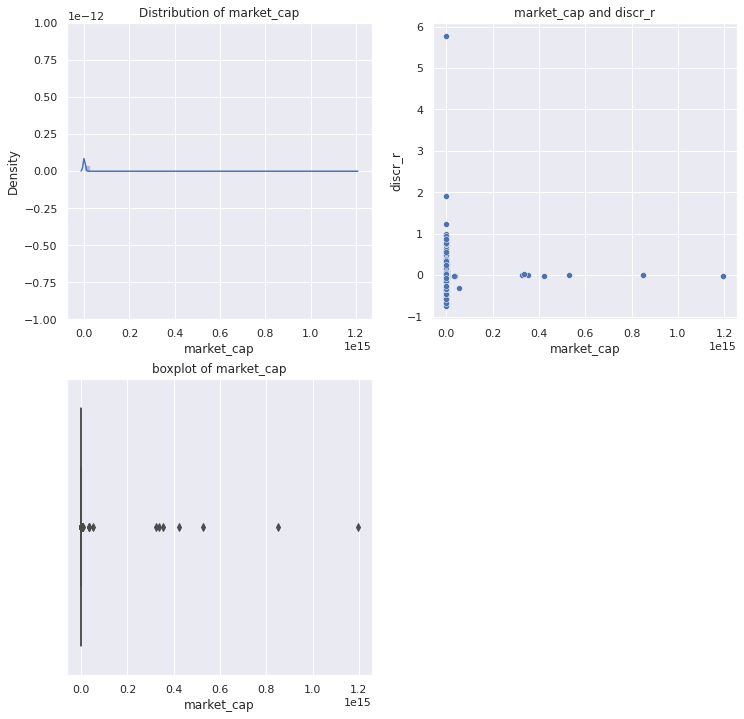

In [ ]:
f= plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(2, 2)

ax=f.add_subplot(gs[0, 0])
sns.distplot(train['market_cap'],bins=50,color='b',ax=ax)
ax.set_title('Distribution of market_cap')

ax=f.add_subplot(gs[0,1])
sns.scatterplot(x='market_cap',y='discr_r',data=train,ax=ax)
ax.set_title('market_cap and discr_r')

ax=f.add_subplot(gs[1, 0])
sns.boxplot(data = train, x= 'market_cap')
ax.set_title('boxplot of market_cap')





**book to market ratio**

In the left plot, we can see the distribution of the *book_to_market*. We can see from this chart that book_to_market is heavily skewed toward zero. On the right, we see the *discr_r* based on the *book_to_market*. We can conclude from this plot that we cannot distinguish "discr_r" based on only "book_to_market", since many data points have almost the same book_to_market, but very different *discr_r*. It can be concluded from the box plot that we have a couple of outliers.







/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 1.0, 'boxplot of book_to_market')

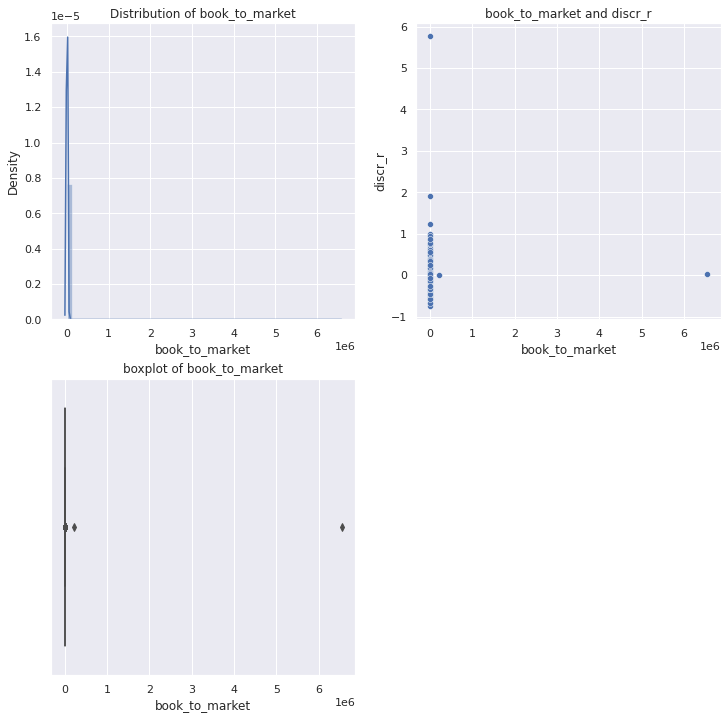

In [ ]:
f= plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(2, 2)

ax=f.add_subplot(gs[0, 0])
sns.distplot(train['book_to_market'],bins=50,color='b',ax=ax)
ax.set_title('Distribution of book_to_market')

ax=f.add_subplot(gs[0,1])
sns.scatterplot(x='book_to_market',y='discr_r',data=train,ax=ax)
ax.set_title('book_to_market and discr_r')

ax=f.add_subplot(gs[1, 0])
sns.boxplot(data = train, x= 'book_to_market')
ax.set_title('boxplot of book_to_market')

**beta**

In the left plot, we can see the distribution of *beta*. This plot shows us that the values of *beta* is skewed toward the right. In the right plot, we can see *discr_r* based on the *beta*. On the basis of this plot, it looks like we have a hard time separating discr_r based on just beta alone, since many of the data points have very different beta but the same discr_r.

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 1.0, 'boxplot of beta')

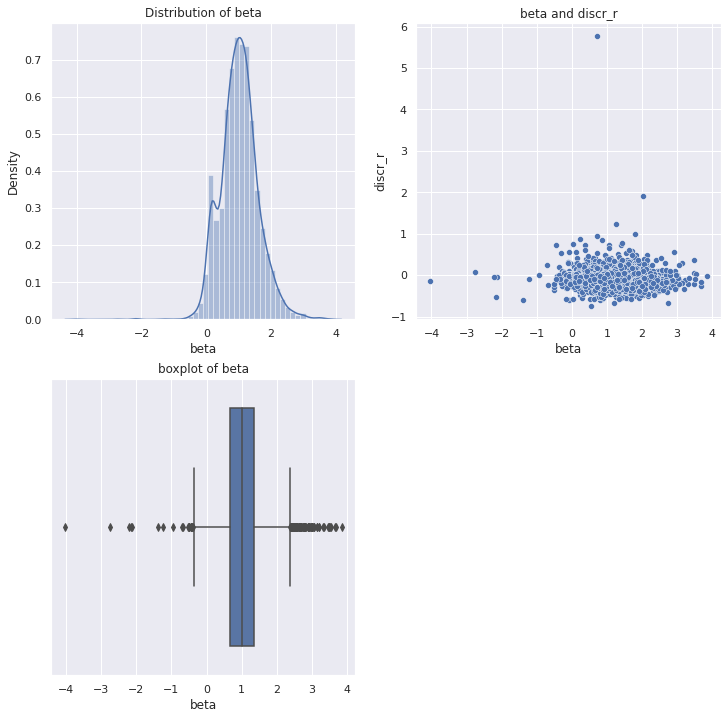

In [ ]:
f= plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(2, 2)

ax=f.add_subplot(gs[0, 0])
sns.distplot(train['beta'],bins=50,color='b',ax=ax)
ax.set_title('Distribution of beta')

ax=f.add_subplot(gs[0,1])
sns.scatterplot(x='beta',y='discr_r',data=train,ax=ax)
ax.set_title('beta and discr_r')

ax=f.add_subplot(gs[1, 0])
sns.boxplot(data = train, x= 'beta')
ax.set_title('boxplot of beta')

# correlation

Based on the following graph, we can say that there is no correlation between our features since all of the values are under 0.1.

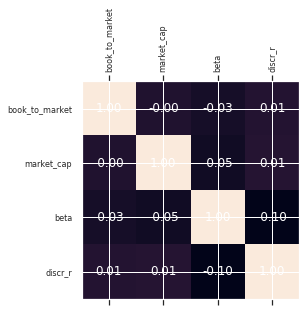

In [ ]:
f ,ax= plt.subplots()
a = train.corr()
plt.xticks(range(a.shape[1]), a.columns, fontsize=8, rotation=90)
plt.yticks(range(a.shape[1]), a.columns, fontsize=8)
im = ax.matshow(a)

ax.set_xticks(np.arange(len(a.columns)))
ax.set_yticks(np.arange(len(a.columns)))

for i,c in enumerate(a.columns):
    for j,h in enumerate(a.columns):
        text = ax.text(j, i, "%0.2f"%a[c][h],
                       ha="center", va="center", color="w")

plt.show()

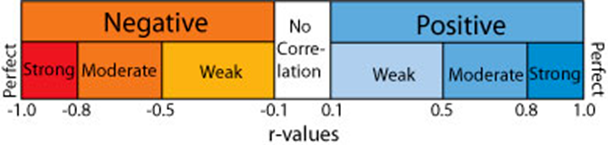

# PCA and data representation

**The principal component analysis (PCA)** technique is widely used for analyzing large datasets that contain many dimensions/features. This method maximizes the interpretation of data while preserving the maximum amount of information, and enables the visualization of multidimensional data.

In order to visualize our data, PCA was used to compress all of our features into one. This allows us to draw the following plot in 2d space and understand our data more.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


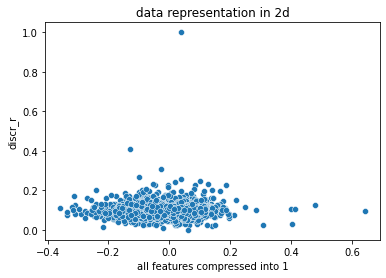

In [ ]:
y_train = train.pop('discr_r')
X_train = train
pca_2d = PCA(n_components=1).fit_transform(X_train)
fig = sns.scatterplot(pca_2d[:, 0], y_train)
plt.xlabel("all features compressed into 1")
plt.ylabel("discr_r")
plt.title("data representation in 2d") # You can comment this line out if you don't need title
plt.show(fig)

# Preprocessing

An aspect of data preparation is data preprocessing, which is any processing applied to raw data before it is subjected to another data processing step. In data preprocessing, we will prepare our data so that it can be easier for machine learning algorithms to process them. This step helps increase the accuracy of our model.

For this dataset, we will only drop the 'Unnamed: 0' column and normalize our values.

In [ ]:
train = train.drop(columns = ['Unnamed: 0'])
scaler = MinMaxScaler()
train[:] = scaler.fit_transform(train[:])
train


,book_to_market,market_cap,beta,discr_r
0,0.000077,1.116980e-05,0.615688,0.119152
1,0.000077,1.197427e-07,0.631420,0.113210
2,0.000077,1.433962e-04,0.659968,0.102126
3,0.000077,1.052218e-05,0.537598,0.110359
4,0.000077,5.227085e-07,0.724688,0.105226
...,...,...,...,...
4878,0.000077,1.816444e-05,0.536984,0.091661
4879,0.000077,4.109551e-06,0.766350,0.073608
4880,0.000077,5.485158e-07,0.640220,0.120333
4881,0.000077,1.796928e-06,0.626909,0.105337


In [ ]:

test = test.drop(columns = ['Unnamed: 0'])
scaler = MinMaxScaler()
test[:] = scaler.fit_transform(test[:])
test


,book_to_market,market_cap,beta,discr_r
0,6.923638e-08,2.966465e-06,0.482783,0.189496
1,6.946169e-08,1.753914e-06,0.621068,0.270020
2,6.955041e-08,2.481874e-07,0.461931,0.201770
3,6.919138e-08,8.128732e-05,0.358120,0.218120
4,7.003459e-08,1.600513e-07,0.571420,0.185199
...,...,...,...,...
5041,6.962445e-08,6.450932e-07,0.503879,0.192194
5042,6.923239e-08,4.654055e-05,0.672715,0.187889
5043,6.920075e-08,1.667364e-07,0.429343,0.123628
5044,6.930833e-08,8.417084e-06,0.575307,0.203718


In [ ]:

validation = validation.drop(columns = ['Unnamed: 0'])
scaler = MinMaxScaler()
validation[:] = scaler.fit_transform(validation[:])
validation


,book_to_market,market_cap,beta,discr_r
0,0.000039,4.076503e-06,0.559739,0.216234
1,0.000039,5.251431e-08,0.757663,0.136581
2,0.000039,1.607182e-06,0.640247,0.208581
3,0.000039,1.071855e-05,0.594675,0.215257
4,0.000039,1.256767e-06,0.704605,0.244462
...,...,...,...,...
4958,0.000039,4.711758e-07,0.560170,0.222041
4959,0.000039,3.775732e-08,0.703146,0.172950
4960,0.000039,5.487544e-07,0.466676,0.217156
4961,0.000039,1.085003e-07,0.669183,0.167897


# linear regression



A **linear regression model** is a supervised machine learning model that analyzes dependent and independent variables and finds what linear relationship, is most suitable

Here we have implemented and trained 2 Linear models one using the sklearn library and one using TensorFlow.

An evaluation metric for regression models is the **Mean absolute error**(MAE). This value is calculated by averaging the errors on all instances in the test dataset. Therefore, the lower this value is, the better our model has performed.

$\mathrm{mae = \dfrac{\sum_{i=1}^{n} |y_i - \hat{y_i}|}{ n}}$

The results show us that the sklearn model has a better performance on our dataset in comparison to the TensorFlow one. Moving forward, we will use the TensorFlow one, since we want to calculate the feature importance and it is very important to us that the neural network model and a linear regression model are from the same library for more consistency.




In [ ]:
y_train = train.pop('discr_r')
X_train = train

y_test = test.pop('discr_r')
X_test = test

y_val = validation.pop('discr_r')
X_val = validation

In [ ]:

linear_regression = LinearRegression() 
linear_regression.fit(X_train, y_train)
y_pred = linear_regression.predict(X_test)


error = mae(y_test, y_pred)
print("Mean absolute error : " + str(error))

Mean absolute error : 0.08715407118739349


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# Shuffle and slice the dataset.
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Now we get a test dataset.
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(64)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(64)

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

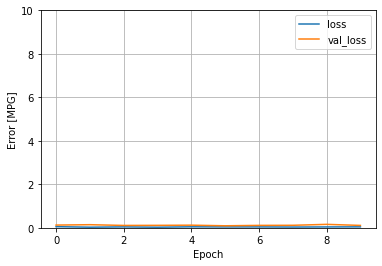

In [ ]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')
history = linear_model.fit(
    X_train,
    y_train,
    epochs=10,
    verbose=0,
    validation_data = val_dataset)
plot_loss(history)

In [ ]:
y_pred = linear_model.predict(X_test)
error = mae(y_test, y_pred)
print("Mean absolute error : " + str(error))

158/158 [==============================] - 0s 1ms/step
Mean absolute error : 0.11406896316076322


# Neural Network




**Neural networks** emulate the way a human brain functions, enabling computers to recognize patterns and solve everyday issues. Artificial neural networks (ANNs) comprise 3 distinct node layers: input, hidden, and output. Nodes, which are artificial neurons, are interconnected and have weights and thresholds related to them. If the output generated by a node surpasses the specified threshold value, the output data will be sent to the succeeding layer.

The neural network model has less MAE on our test data. meaning that it has performed better on this dataset in comparison to linear regression.




Epoch 1/10
153/153 [==============================] - 2s 4ms/step - loss: 0.0269 - val_loss: 0.0996
Epoch 2/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0149 - val_loss: 0.0995
Epoch 3/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0148 - val_loss: 0.0978
Epoch 4/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0148 - val_loss: 0.1018
Epoch 5/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0149 - val_loss: 0.1022
Epoch 6/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0148 - val_loss: 0.1003
Epoch 7/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0148 - val_loss: 0.1014
Epoch 8/10
153/153 [==============================] - 2s 13ms/step - loss: 0.0148 - val_loss: 0.1001
Epoch 9/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0148 - val_loss: 0.1022
Epoch 10/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0148 - val_loss: 0.098

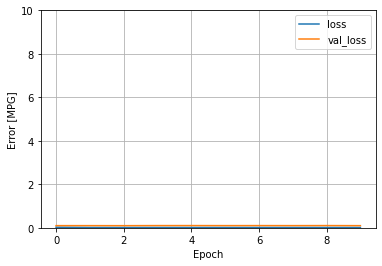

In [ ]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))
neural_network = Sequential() # initialize neural network
neural_network.add(normalizer)
neural_network.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
neural_network.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'relu'))
neural_network.add(Dense(units = 1))
neural_network.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mean_absolute_error')
history = neural_network.fit(
    X_train,
    y_train,
    epochs=10,
    validation_data = val_dataset)
plot_loss(history)

In [ ]:
y_pred = neural_network.predict(X_test)
error = mae(y_test, y_pred)
print("Mean absolute error : " + str(error))

158/158 [==============================] - 0s 1ms/step
Mean absolute error : 0.08362879505916126


# Feature Importance

feature importance can be used to calculate a score for each of the features we have in our dataset. We can determine how important each feature is to the model based on these scores.   This means that  Feature scores indicate how much impact a feature will have on the model outcome.

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import mode
import tensorflow as tf


# a function for feature analysis
def feature_analysis(X, model, feature_names):
    # determine first and second partial derivatives
    with tf.GradientTape() as snd:
        snd.watch(X)
        with tf.GradientTape() as fst:
            fst.watch(X)
            # prediction with the neural network, i.e., f(X)
            pred = model(X)
        # gradient
        g = fst.gradient(pred, X)
    # jacobian which outputs Hessian matrix
    h = snd.batch_jacobian(g, X)

    # first partial derivatives
    g_np = g.numpy()
    # average squard partial derivatives
    g_mag_sq = (g_np**2).mean(axis = 0)
    # square root of average squard partial derivatives
    g_mag = np.sqrt(g_mag_sq)
    # sign of average partial derivatives
    g_dir = np.sign(g_np.mean(axis = 0))

    # normalizing constant
    C_ = np.sum(g_mag)
    # normalized feature importance with sign
    fi = (g_mag * g_dir) / C_

    # get signs of each sample
    fi_signs = np.sign(g_np)
    # the mode is the sign which can be observed most often among all samples, the counts is how often this sign is observed
    fi_modes, fi_counts = mode(fi_signs)
    # dividing the count of the sign which is observed most often by the overall sample size gives us a frequency measure
    # which is closer to one, the higher the conformity of the sign
    fi_conformity = fi_counts / g_np.shape[0] #fi_modes * 

    # in analogy to the calculation above, we do the same thing with the second partial derivatives
    h_np = h.numpy()
    # get the square root of average squared direction of curvature and interactions
    h_mag_sq = (h_np**2).mean(axis = 0)
    h_mag = np.sqrt(h_mag_sq)

    # the the sign of average curvature and interactions
    h_dir = np.sign(h_np.mean(axis = 0))

    # normalize the values on the diagonal line to compare the degree of non-linearity
    C_nonlin = np.sum(h_mag.diagonal())
    nonlinearity = (h_dir.diagonal() * h_mag.diagonal()) / C_nonlin

    # normlize the interactions
    lti = np.tril_indices(h_mag.shape[0], k = -1)
    C_ia = np.sum(h_mag[lti])
    interactions = (h_mag[lti] * h_dir[lti]) / C_ia

    # bring curvature and interaction effects back to matrix format
    snd_degree_summary = np.diag(nonlinearity)
    a, b = lti
    inter_iter = iter(interactions)
    for i, j in zip(a, b):
        snd_degree_summary[i, j] = next(inter_iter)
        snd_degree_summary[j, i] = snd_degree_summary[i, j]

    # get the conformity of second order effects
    snd_signs = np.sign(h_np)
    snd_degree_modes, snd_degreee_counts = mode(snd_signs)
    snd_degree_conformity = snd_degreee_counts / h_np.shape[0] #snd_degree_modes * 

    # finally summarize feature importances and second order effects
    summary = pd.DataFrame(data = snd_degree_summary, index = feature_names, columns = feature_names)
    summary.loc[:, 'feature_importance'] = fi
    # as well as their conformity
    summary_conformity = pd.DataFrame(data = snd_degree_conformity.reshape(h_np.shape[1], h_np.shape[2]), index = feature_names, columns = feature_names)
    summary_conformity.loc[:, 'feature_importance'] = fi_conformity.flatten()

    return summary, summary_conformity



**for benchmark linear regrssion**

Based on the feature importance graphs we can understand that market_cap has the most importance but it's impact is negative. Next comes Book_to_market with a positive impact. and beta has an almost zero impact. Since the conformity is 1.0, it means that for 100% of time these values are correct. The importance for the test dataset is the same as the train dataset.

with respect to $(R_{Mt} - R_{ft})$ , SMB and HML, we can conclude that the linear regression model has almost no sensitivity of asset return towards market portfolio, it mostly concentrates on how asset behaves for a large company and a company with high book_to_market value.


<ipython-input-10-1f5cc1f7b3cd>:54: RuntimeWarning:

invalid value encountered in true_divide

<ipython-input-10-1f5cc1f7b3cd>:59: RuntimeWarning:

invalid value encountered in true_divide



,book_to_market,market_cap,beta,feature_importance
book_to_market,1.0,1.0,1.0,1.0
market_cap,1.0,1.0,1.0,1.0
beta,1.0,1.0,1.0,1.0


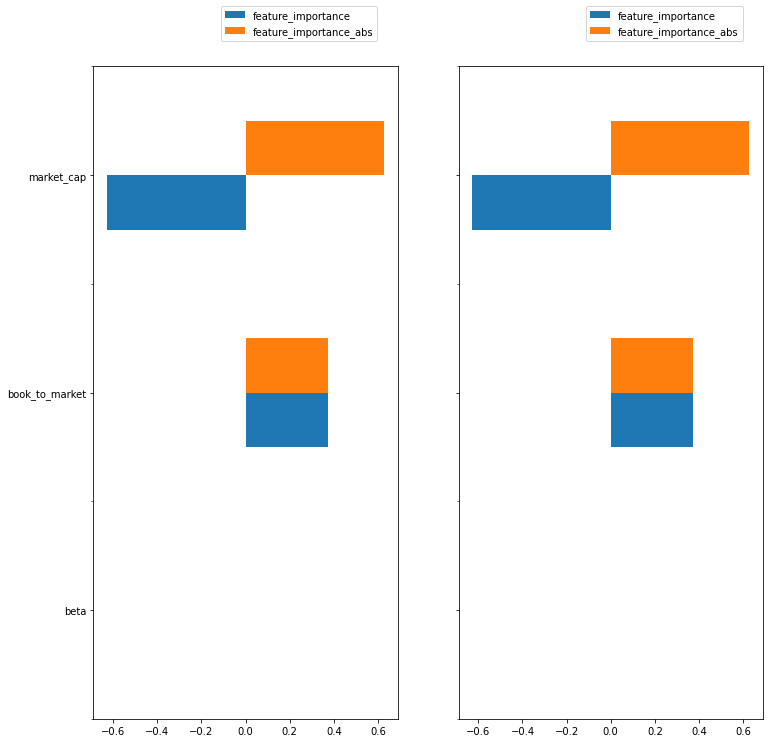

In [ ]:
my_model = linear_model
X_train_tensor = tf.Variable(X_train)
X_test_tensor = tf.Variable(X_test)
sum, sum_c = feature_analysis(X_train_tensor, my_model, X_train.columns)
sum_test, sum_c_test = feature_analysis(X_test_tensor, my_model, X_train.columns)

fig,axs = plt.subplots(1,2, figsize=(12,12), sharey= True)

fi_train = pd.DataFrame(sum["feature_importance"])
fi_train.loc[:, "feature_importance_abs"] = fi_train.feature_importance.abs()
fi_train.sort_values(by="feature_importance_abs", ascending=True, inplace =True)
fi_train.plot.barh(ax=axs[0])

fi_test = pd.DataFrame(sum_test["feature_importance"])
fi_test.loc[:, "feature_importance_abs"] = fi_test.feature_importance.abs()
fi_test.sort_values(by="feature_importance_abs", ascending=True, inplace =True)
fi_test.plot.barh(ax=axs[1])

axs[0].legend(bbox_to_anchor=(0.95,1.1))
axs[1].legend(bbox_to_anchor=(0.95,1.1))

display(sum_c)

**for neural network**

Based on the feature importance graphs we can understand that Book_to_market has the most important and it's impact is positive. Next comes beta with a negative impact. Finally, market_cap has the least importance with a negative impact. the importance of book_to_market for the test is almost the same as the difffrence of the sign. For the other two features, the importance is less in the test in comparison to train. The conformity for book_to_market is 84% but for the other two features is almost 100%.

with respect to $(R_{Mt} - R_{ft})$ , SMB and HML, we can conclude that the neural network model has a negative sensitivity of asset return towards market portfolio, it mostly concentrates on how asset behaves for a large company and a company with high book_to_market value.


<ipython-input-10-1f5cc1f7b3cd>:54: RuntimeWarning:

invalid value encountered in true_divide

<ipython-input-10-1f5cc1f7b3cd>:59: RuntimeWarning:

invalid value encountered in true_divide



,book_to_market,market_cap,beta,feature_importance
book_to_market,1.0,1.0,1.0,0.844563
market_cap,1.0,1.0,1.0,0.998566
beta,1.0,1.0,1.0,1.000000


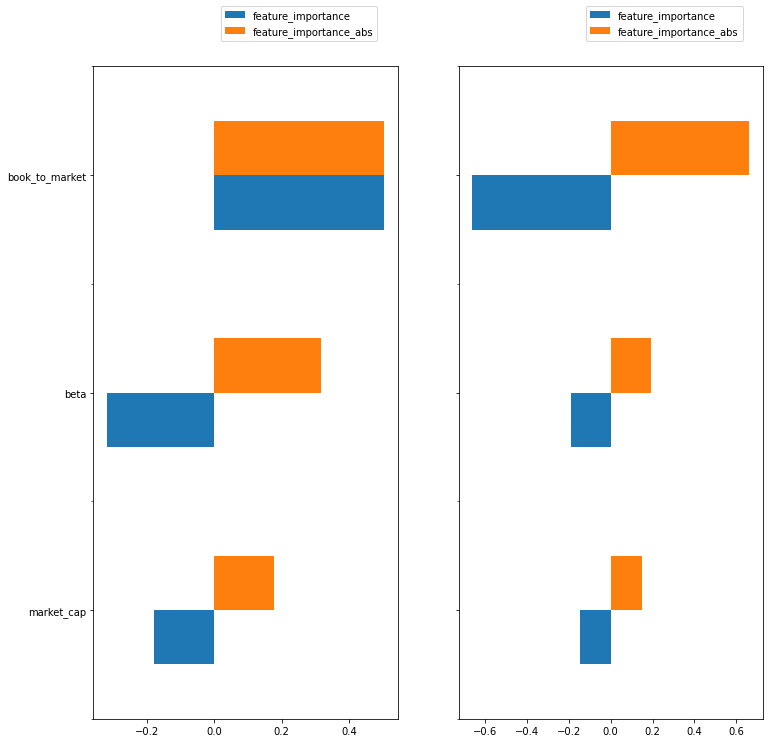

In [ ]:
my_model = neural_network
X_train_tensor = tf.Variable(X_train)
X_test_tensor = tf.Variable(X_test)
sum, sum_c = feature_analysis(X_train_tensor, my_model, X_train.columns)
sum_test, sum_c_test = feature_analysis(X_test_tensor, my_model, X_train.columns)

fig,axs = plt.subplots(1,2, figsize=(12,12), sharey= True)

fi_train = pd.DataFrame(sum["feature_importance"])
fi_train.loc[:, "feature_importance_abs"] = fi_train.feature_importance.abs()
fi_train.sort_values(by="feature_importance_abs", ascending=True, inplace =True)
fi_train.plot.barh(ax=axs[0])

fi_test = pd.DataFrame(sum_test["feature_importance"])
fi_test.loc[:, "feature_importance_abs"] = fi_test.feature_importance.abs()
fi_test.sort_values(by="feature_importance_abs", ascending=True, inplace =True)
fi_test.plot.barh(ax=axs[1])

axs[0].legend(bbox_to_anchor=(0.95,1.1))
axs[1].legend(bbox_to_anchor=(0.95,1.1))

display(sum_c)

# optimization

For optimizing our neural network and finding the best set of hyperparameters, we will use Optuna.
Optuna is a python library that allows us to automate hyperparameter search and optimize our model.
In order to use Optuna, we need to define an objective. Optuna algorithm will try to minimize this value. In this assignment, we have used Mean absolute error as our objective.
The hyperparameters that we are looking for are the layer count and node count in each layer. The layer count is between 1 to 7 and the node count is between 4 to 128. We try optimizing our model in 50 trials. 
if we compare the results from the optimized neural network to the baseline neural network, we can see that we had a very small decrease in our MAE value. 

 Based on the feature importance graphs we can understand that Book_to_market has the most importance and it's impact is positive. Next comes market_cap with a positive impact. Finally, beta has the least importance with a negative impact. The importance for test is very close to train.  The conformity for market_cap is 88% but for the other two features is almost 100%.

 with respect to $(R_{Mt} - R_{ft})$ , SMB and HML, we can conclude that the optimized neural network model has a negative sensitivity of asset return towards market portfolio, it mostly concentrates on how asset behaves for a small company and a company with high book_to_market value.

In [ ]:
def create_model(trial):
  normalizer = tf.keras.layers.Normalization(axis=-1)
  normalizer.adapt(np.array(X_train))

  n_layers = trial.suggest_int('n_layers', 1, 7)
  # print(n_layers)
  model = tf.keras.Sequential()
  model.add(normalizer)
  for i in range(n_layers-1):
    
    activation = trial.suggest_categorical(f"activation_l{i}",["tanh", "sigmoid","relu"])
    num_hidden = trial.suggest_int(f'n_units_l{i}', 4, 128, log=True)
    # print(num_hidden)
    # print(activation)
    model.add(tf.keras.layers.Dense(units = num_hidden, kernel_initializer = 'uniform', activation=activation))
  model.add(tf.keras.layers.Dense(1))
  model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss ='mean_absolute_error')
  return model

In [ ]:
# Function to get hardware strategy
def get_hardware_strategy():
    try:
        # TPU detection. No parameters necessary if TPU_NAME environment variable is
        # set: this is always the case on Kaggle.
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        tpu = None

    if tpu:
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        tf.config.optimizer.set_jit(True)
    else:
        # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
        strategy = tf.distribute.get_strategy()

    return tpu, strategy

tpu, strategy = get_hardware_strategy()

In [ ]:
def objective(trial):
    
    keras.backend.clear_session()
    
    model = create_model(trial)

    
    model.fit(
        X_train,
        y_train,
        callbacks=[TFKerasPruningCallback(trial, "val_loss")],
        epochs=10,
        validation_data=val_dataset
    )
    y_pred = model.predict(X_test)
    score = mae(y_test,y_pred)
    return score



In [ ]:
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective, n_trials=50)
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
plot_optimization_history(study)

[I 2022-12-20 23:50:53,171] A new study created in memory with name: no-name-f744b565-3072-41ed-8b00-bde65c4f9a41


Epoch 1/10
153/153 [==============================] - 2s 8ms/step - loss: 0.0250 - val_loss: 0.0925
Epoch 2/10
153/153 [==============================] - 1s 8ms/step - loss: 0.0183 - val_loss: 0.0822
Epoch 3/10
153/153 [==============================] - 1s 8ms/step - loss: 0.0182 - val_loss: 0.0941
Epoch 4/10
153/153 [==============================] - 1s 9ms/step - loss: 0.0194 - val_loss: 0.1060
Epoch 5/10
153/153 [==============================] - 1s 8ms/step - loss: 0.0189 - val_loss: 0.0889
Epoch 6/10
153/153 [==============================] - 2s 11ms/step - loss: 0.0195 - val_loss: 0.0949
Epoch 7/10
153/153 [==============================] - 1s 8ms/step - loss: 0.0168 - val_loss: 0.0926
Epoch 8/10
153/153 [==============================] - 1s 8ms/step - loss: 0.0177 - val_loss: 0.0998
Epoch 9/10
153/153 [==============================] - 1s 8ms/step - loss: 0.0178 - val_loss: 0.1135
Epoch 10/10
158/158 [==============================] - 0s 1ms/step


[I 2022-12-20 23:51:08,016] Trial 0 finished with value: 0.09734662517280275 and parameters: {'n_layers': 6, 'activation_l0': 'tanh', 'n_units_l0': 7, 'activation_l1': 'sigmoid', 'n_units_l1': 121, 'activation_l2': 'relu', 'n_units_l2': 9, 'activation_l3': 'sigmoid', 'n_units_l3': 115, 'activation_l4': 'relu', 'n_units_l4': 46}. Best is trial 0 with value: 0.09734662517280275.


Epoch 1/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0214 - val_loss: 0.1029
Epoch 2/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0148 - val_loss: 0.0985
Epoch 3/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0149 - val_loss: 0.0993
Epoch 4/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0148 - val_loss: 0.1038
Epoch 5/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0149 - val_loss: 0.1010
Epoch 6/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0148 - val_loss: 0.0944
Epoch 7/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0148 - val_loss: 0.1019
Epoch 8/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0148 - val_loss: 0.1018
Epoch 9/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0148 - val_loss: 0.1017
Epoch 10/10
158/158 [==============================] - 0s 1ms/step


[I 2022-12-20 23:51:14,610] Trial 1 finished with value: 0.08861970962115406 and parameters: {'n_layers': 4, 'activation_l0': 'relu', 'n_units_l0': 115, 'activation_l1': 'relu', 'n_units_l1': 18, 'activation_l2': 'relu', 'n_units_l2': 10}. Best is trial 1 with value: 0.08861970962115406.


Epoch 1/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0455 - val_loss: 0.0894
Epoch 2/10
134/153 [=========================>....] - ETA: 0s - loss: 0.0161

[I 2022-12-20 23:51:16,715] Trial 2 pruned. Trial was pruned at epoch 1.


Epoch 1/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0196 - val_loss: 0.0989
Epoch 2/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0150 - val_loss: 0.0970
Epoch 3/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0150 - val_loss: 0.0975
Epoch 4/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0150 - val_loss: 0.0988
Epoch 5/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0149 - val_loss: 0.1005
Epoch 6/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0149 - val_loss: 0.0889
Epoch 7/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0152 - val_loss: 0.1019
Epoch 8/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0148 - val_loss: 0.0985
Epoch 9/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0149 - val_loss: 0.0993
Epoch 10/10
140/153 [==========================>...] - ETA: 0s - loss: 0.0148

[I 2022-12-20 23:51:22,822] Trial 3 pruned. Trial was pruned at epoch 9.


Epoch 1/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0221 - val_loss: 0.1017
Epoch 2/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0167 - val_loss: 0.0935
Epoch 3/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0160 - val_loss: 0.1113
Epoch 4/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0159 - val_loss: 0.1017
Epoch 5/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0156 - val_loss: 0.1044
Epoch 6/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0157 - val_loss: 0.0988
Epoch 7/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0161 - val_loss: 0.1032
Epoch 8/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0154 - val_loss: 0.1085
Epoch 9/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0152 - val_loss: 0.1000
Epoch 10/10
158/158 [==============================] - 0s 2ms/step


[I 2022-12-20 23:51:34,455] Trial 4 finished with value: 0.08317347767888657 and parameters: {'n_layers': 6, 'activation_l0': 'relu', 'n_units_l0': 122, 'activation_l1': 'sigmoid', 'n_units_l1': 32, 'activation_l2': 'sigmoid', 'n_units_l2': 31, 'activation_l3': 'sigmoid', 'n_units_l3': 35, 'activation_l4': 'relu', 'n_units_l4': 14}. Best is trial 4 with value: 0.08317347767888657.


Epoch 1/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0197 - val_loss: 0.1001
Epoch 2/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0153 - val_loss: 0.1013
Epoch 3/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0150 - val_loss: 0.1014
Epoch 4/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0150 - val_loss: 0.1005
Epoch 5/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0150 - val_loss: 0.1000
Epoch 6/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0152 - val_loss: 0.1057
Epoch 7/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0150 - val_loss: 0.0968
Epoch 8/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0149 - val_loss: 0.1001
Epoch 9/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0149 - val_loss: 0.1004
Epoch 10/10
158/158 [==============================] - 0s 1ms/step


[I 2022-12-20 23:51:40,797] Trial 5 finished with value: 0.0830363802092977 and parameters: {'n_layers': 3, 'activation_l0': 'relu', 'n_units_l0': 45, 'activation_l1': 'tanh', 'n_units_l1': 36}. Best is trial 5 with value: 0.0830363802092977.


Epoch 1/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0202 - val_loss: 0.1009
Epoch 2/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0153 - val_loss: 0.0961
Epoch 3/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0152 - val_loss: 0.1019
Epoch 4/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0152 - val_loss: 0.0996
Epoch 5/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0154 - val_loss: 0.1039
Epoch 6/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0153 - val_loss: 0.1013
Epoch 7/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0152 - val_loss: 0.0989
Epoch 8/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0154 - val_loss: 0.1011
Epoch 9/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0153 - val_loss: 0.0946
Epoch 10/10
152/153 [============================>.] - ETA: 0s - loss: 0.0150

[I 2022-12-20 23:51:46,888] Trial 6 pruned. Trial was pruned at epoch 9.


Epoch 1/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0904 - val_loss: 0.1014
Epoch 2/10
134/153 [=========================>....] - ETA: 0s - loss: 0.0157

[I 2022-12-20 23:51:48,846] Trial 7 pruned. Trial was pruned at epoch 1.


Epoch 1/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0291 - val_loss: 0.1044
Epoch 2/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0152 - val_loss: 0.0989
Epoch 3/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0152 - val_loss: 0.1009
Epoch 4/10
145/153 [===========================>..] - ETA: 0s - loss: 0.0154

[I 2022-12-20 23:51:52,443] Trial 8 pruned. Trial was pruned at epoch 3.


Epoch 1/10
153/153 [==============================] - 1s 4ms/step - loss: 0.3747 - val_loss: 0.3370
Epoch 2/10
149/153 [============================>.] - ETA: 0s - loss: 0.2594

[I 2022-12-20 23:51:54,335] Trial 9 pruned. Trial was pruned at epoch 1.


Epoch 1/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0967 - val_loss: 0.1322
Epoch 2/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0464 - val_loss: 0.1305
Epoch 3/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0453 - val_loss: 0.1292
Epoch 4/10
138/153 [==========================>...] - ETA: 0s - loss: 0.0313

[I 2022-12-20 23:51:57,780] Trial 10 pruned. Trial was pruned at epoch 3.


Epoch 1/10
153/153 [==============================] - 1s 3ms/step - loss: 0.7799 - val_loss: 0.9202
Epoch 2/10
135/153 [=========================>....] - ETA: 0s - loss: 0.6643

[I 2022-12-20 23:51:59,362] Trial 11 pruned. Trial was pruned at epoch 1.


Epoch 1/10
153/153 [==============================] - 2s 4ms/step - loss: 0.0213 - val_loss: 0.0999
Epoch 2/10
153/153 [==============================] - 2s 11ms/step - loss: 0.0152 - val_loss: 0.1017
Epoch 3/10
153/153 [==============================] - 1s 7ms/step - loss: 0.0153 - val_loss: 0.1019
Epoch 4/10
153/153 [==============================] - 2s 14ms/step - loss: 0.0155 - val_loss: 0.0993
Epoch 5/10
153/153 [==============================] - 2s 13ms/step - loss: 0.0149 - val_loss: 0.1029
Epoch 6/10
153/153 [==============================] - 2s 12ms/step - loss: 0.0148 - val_loss: 0.0988
Epoch 7/10
153/153 [==============================] - 2s 13ms/step - loss: 0.0149 - val_loss: 0.1002
Epoch 8/10
153/153 [==============================] - 1s 6ms/step - loss: 0.0148 - val_loss: 0.1022
Epoch 9/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0148 - val_loss: 0.0995
Epoch 10/10
142/153 [==========================>...] - ETA: 0s - loss: 0.0148

[I 2022-12-20 23:52:14,209] Trial 12 pruned. Trial was pruned at epoch 9.


Epoch 1/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0236 - val_loss: 0.0993
Epoch 2/10
147/153 [===========================>..] - ETA: 0s - loss: 0.0148

[I 2022-12-20 23:52:16,291] Trial 13 pruned. Trial was pruned at epoch 1.


Epoch 1/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0247 - val_loss: 0.0949
Epoch 2/10
152/153 [============================>.] - ETA: 0s - loss: 0.0174

[I 2022-12-20 23:52:18,264] Trial 14 pruned. Trial was pruned at epoch 1.


Epoch 1/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0170 - val_loss: 0.1001
Epoch 2/10
146/153 [===========================>..] - ETA: 0s - loss: 0.0152

[I 2022-12-20 23:52:20,392] Trial 15 pruned. Trial was pruned at epoch 1.


Epoch 1/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0200 - val_loss: 0.0967
Epoch 2/10
137/153 [=========================>....] - ETA: 0s - loss: 0.0152

[I 2022-12-20 23:52:22,145] Trial 16 pruned. Trial was pruned at epoch 1.


Epoch 1/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0353 - val_loss: 0.0983
Epoch 2/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0154 - val_loss: 0.0951
Epoch 3/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0155 - val_loss: 0.0985
Epoch 4/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0152 - val_loss: 0.0982
Epoch 5/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0150 - val_loss: 0.0999
Epoch 6/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0153 - val_loss: 0.0967
Epoch 7/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0151 - val_loss: 0.0968
Epoch 8/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0152 - val_loss: 0.1009
Epoch 9/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0154 - val_loss: 0.1019
Epoch 10/10
153/153 [==============================] - ETA: 0s - loss: 0.0154

[I 2022-12-20 23:52:28,894] Trial 17 pruned. Trial was pruned at epoch 9.


Epoch 1/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0172 - val_loss: 0.0944
Epoch 2/10
141/153 [==========================>...] - ETA: 0s - loss: 0.0159

[I 2022-12-20 23:52:36,291] Trial 18 pruned. Trial was pruned at epoch 1.


Epoch 1/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0188 - val_loss: 0.0972
Epoch 2/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0154 - val_loss: 0.1023
Epoch 3/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0153 - val_loss: 0.0994
Epoch 4/10
141/153 [==========================>...] - ETA: 0s - loss: 0.0154

[I 2022-12-20 23:52:39,361] Trial 19 pruned. Trial was pruned at epoch 3.


Epoch 1/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0215 - val_loss: 0.0971
Epoch 2/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0149 - val_loss: 0.0982
Epoch 3/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0148 - val_loss: 0.1004
Epoch 4/10
131/153 [========================>.....] - ETA: 0s - loss: 0.0149

[I 2022-12-20 23:52:41,988] Trial 20 pruned. Trial was pruned at epoch 3.


Epoch 1/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0189 - val_loss: 0.1024
Epoch 2/10
151/153 [============================>.] - ETA: 0s - loss: 0.0149

[I 2022-12-20 23:52:43,960] Trial 21 pruned. Trial was pruned at epoch 1.


Epoch 1/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0243 - val_loss: 0.1029
Epoch 2/10
152/153 [============================>.] - ETA: 0s - loss: 0.0148

[I 2022-12-20 23:52:45,911] Trial 22 pruned. Trial was pruned at epoch 1.


Epoch 1/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0209 - val_loss: 0.1018
Epoch 2/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0148 - val_loss: 0.0973
Epoch 3/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0148 - val_loss: 0.0969
Epoch 4/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0149 - val_loss: 0.0970
Epoch 5/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0149 - val_loss: 0.1020
Epoch 6/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0148 - val_loss: 0.1031
Epoch 7/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0148 - val_loss: 0.1024
Epoch 8/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0148 - val_loss: 0.1000
Epoch 9/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0148 - val_loss: 0.1029
Epoch 10/10
148/153 [============================>.] - ETA: 0s - loss: 0.0148

[I 2022-12-20 23:52:52,271] Trial 23 pruned. Trial was pruned at epoch 9.


Epoch 1/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0311 - val_loss: 0.0997
Epoch 2/10
153/153 [==============================] - 0s 2ms/step - loss: 0.0148 - val_loss: 0.1010
Epoch 3/10
153/153 [==============================] - 0s 2ms/step - loss: 0.0148 - val_loss: 0.1000
Epoch 4/10
138/153 [==========================>...] - ETA: 0s - loss: 0.0148

[I 2022-12-20 23:52:54,856] Trial 24 pruned. Trial was pruned at epoch 3.


Epoch 1/10
153/153 [==============================] - 1s 3ms/step - loss: 0.3906 - val_loss: 0.1097
Epoch 2/10
147/153 [===========================>..] - ETA: 0s - loss: 0.0162

[I 2022-12-20 23:52:56,631] Trial 25 pruned. Trial was pruned at epoch 1.


Epoch 1/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0255 - val_loss: 0.1028
Epoch 2/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0148 - val_loss: 0.0982
Epoch 3/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0147 - val_loss: 0.0996
Epoch 4/10
134/153 [=========================>....] - ETA: 0s - loss: 0.0149

[I 2022-12-20 23:53:00,015] Trial 26 pruned. Trial was pruned at epoch 3.


Epoch 1/10
153/153 [==============================] - 1s 4ms/step - loss: 0.3458 - val_loss: 0.1028
Epoch 2/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0155 - val_loss: 0.0983
Epoch 3/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0155 - val_loss: 0.1010
Epoch 4/10
144/153 [===========================>..] - ETA: 0s - loss: 0.0153

[I 2022-12-20 23:53:03,009] Trial 27 pruned. Trial was pruned at epoch 3.


Epoch 1/10
153/153 [==============================] - 1s 4ms/step - loss: 0.1272 - val_loss: 0.1050
Epoch 2/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0149 - val_loss: 0.0985
Epoch 3/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0149 - val_loss: 0.0984
Epoch 4/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0149 - val_loss: 0.1003
Epoch 5/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0149 - val_loss: 0.1078
Epoch 6/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0151 - val_loss: 0.1040
Epoch 7/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0149 - val_loss: 0.1038
Epoch 8/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0152 - val_loss: 0.0978
Epoch 9/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0152 - val_loss: 0.0981
Epoch 10/10
153/153 [==============================] - ETA: 0s - loss: 0.0149

[I 2022-12-20 23:53:08,426] Trial 28 pruned. Trial was pruned at epoch 9.


Epoch 1/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0214 - val_loss: 0.0977
Epoch 2/10
136/153 [=========================>....] - ETA: 0s - loss: 0.0156

[I 2022-12-20 23:53:10,328] Trial 29 pruned. Trial was pruned at epoch 1.


Epoch 1/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0183 - val_loss: 0.1028
Epoch 2/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0150 - val_loss: 0.1090
Epoch 3/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0148 - val_loss: 0.1029
Epoch 4/10
151/153 [============================>.] - ETA: 0s - loss: 0.0150

[I 2022-12-20 23:53:13,339] Trial 30 pruned. Trial was pruned at epoch 3.


Epoch 1/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0246 - val_loss: 0.0994
Epoch 2/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0151 - val_loss: 0.0976
Epoch 3/10
153/153 [==============================] - 0s 2ms/step - loss: 0.0154 - val_loss: 0.1037
Epoch 4/10
150/153 [============================>.] - ETA: 0s - loss: 0.0155

[I 2022-12-20 23:53:16,192] Trial 31 pruned. Trial was pruned at epoch 3.


Epoch 1/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0210 - val_loss: 0.0958
Epoch 2/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0153 - val_loss: 0.1023
Epoch 3/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0152 - val_loss: 0.1024
Epoch 4/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0153 - val_loss: 0.1006
Epoch 5/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0152 - val_loss: 0.0985
Epoch 6/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0150 - val_loss: 0.1059
Epoch 7/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0149 - val_loss: 0.1028
Epoch 8/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0148 - val_loss: 0.0998
Epoch 9/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0148 - val_loss: 0.1031
Epoch 10/10
149/153 [============================>.] - ETA: 0s - loss: 0.0147

[I 2022-12-20 23:53:23,460] Trial 32 pruned. Trial was pruned at epoch 9.


Epoch 1/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0233 - val_loss: 0.0979
Epoch 2/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0149 - val_loss: 0.0974
Epoch 3/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0148 - val_loss: 0.1009
Epoch 4/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0148 - val_loss: 0.0977
Epoch 5/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0148 - val_loss: 0.1040
Epoch 6/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0149 - val_loss: 0.0998
Epoch 7/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0148 - val_loss: 0.1015
Epoch 8/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0148 - val_loss: 0.0998
Epoch 9/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0149 - val_loss: 0.1048
Epoch 10/10
145/153 [===========================>..] - ETA: 0s - loss: 0.0149

[I 2022-12-20 23:53:34,569] Trial 33 pruned. Trial was pruned at epoch 9.


Epoch 1/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0259 - val_loss: 0.1007
Epoch 2/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0151 - val_loss: 0.1024
Epoch 3/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0150 - val_loss: 0.1013
Epoch 4/10
153/153 [==============================] - 0s 2ms/step - loss: 0.0149 - val_loss: 0.0997
Epoch 5/10
153/153 [==============================] - 0s 2ms/step - loss: 0.0150 - val_loss: 0.0993
Epoch 6/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0149 - val_loss: 0.0994
Epoch 7/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0150 - val_loss: 0.1015
Epoch 8/10
153/153 [==============================] - 0s 2ms/step - loss: 0.0151 - val_loss: 0.0996
Epoch 9/10
153/153 [==============================] - 0s 2ms/step - loss: 0.0150 - val_loss: 0.0988
Epoch 10/10
131/153 [========================>.....] - ETA: 0s - loss: 0.0150

[I 2022-12-20 23:53:44,151] Trial 34 pruned. Trial was pruned at epoch 9.


Epoch 1/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0208 - val_loss: 0.1010
Epoch 2/10
153/153 [==============================] - ETA: 0s - loss: 0.0149

[I 2022-12-20 23:53:47,972] Trial 35 pruned. Trial was pruned at epoch 1.


Epoch 1/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0182 - val_loss: 0.0994
Epoch 2/10
142/153 [==========================>...] - ETA: 0s - loss: 0.0151

[I 2022-12-20 23:53:50,468] Trial 36 pruned. Trial was pruned at epoch 1.


Epoch 1/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0226 - val_loss: 0.0993
Epoch 2/10
132/153 [========================>.....] - ETA: 0s - loss: 0.0148

[I 2022-12-20 23:53:52,651] Trial 37 pruned. Trial was pruned at epoch 1.


Epoch 1/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0179 - val_loss: 0.1016
Epoch 2/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0149 - val_loss: 0.0956
Epoch 3/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0151 - val_loss: 0.0971
Epoch 4/10
144/153 [===========================>..] - ETA: 0s - loss: 0.0150

[I 2022-12-20 23:53:55,958] Trial 38 pruned. Trial was pruned at epoch 3.


Epoch 1/10
153/153 [==============================] - 1s 5ms/step - loss: 0.0626 - val_loss: 0.1010
Epoch 2/10
142/153 [==========================>...] - ETA: 0s - loss: 0.0152

[I 2022-12-20 23:53:58,470] Trial 39 pruned. Trial was pruned at epoch 1.


Epoch 1/10
153/153 [==============================] - 1s 4ms/step - loss: 0.3254 - val_loss: 0.1066
Epoch 2/10
150/153 [============================>.] - ETA: 0s - loss: 0.0151

[I 2022-12-20 23:54:02,049] Trial 40 pruned. Trial was pruned at epoch 1.


Epoch 1/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0195 - val_loss: 0.1013
Epoch 2/10
137/153 [=========================>....] - ETA: 0s - loss: 0.0147

[I 2022-12-20 23:54:04,000] Trial 41 pruned. Trial was pruned at epoch 1.


Epoch 1/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0723 - val_loss: 0.1001
Epoch 2/10
153/153 [==============================] - 1s 6ms/step - loss: 0.0149 - val_loss: 0.1050
Epoch 3/10
153/153 [==============================] - 1s 7ms/step - loss: 0.0150 - val_loss: 0.1031
Epoch 4/10
153/153 [==============================] - 1s 7ms/step - loss: 0.0150 - val_loss: 0.1010
Epoch 5/10
153/153 [==============================] - 1s 6ms/step - loss: 0.0149 - val_loss: 0.1018
Epoch 6/10
153/153 [==============================] - 1s 6ms/step - loss: 0.0149 - val_loss: 0.1013
Epoch 7/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0150 - val_loss: 0.1024
Epoch 8/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0150 - val_loss: 0.0985
Epoch 9/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0149 - val_loss: 0.0997
Epoch 10/10
135/153 [=========================>....] - ETA: 0s - loss: 0.0151

[I 2022-12-20 23:54:12,837] Trial 42 pruned. Trial was pruned at epoch 9.


Epoch 1/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0209 - val_loss: 0.1009
Epoch 2/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0152 - val_loss: 0.1003
Epoch 3/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0151 - val_loss: 0.0953
Epoch 4/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0150 - val_loss: 0.1020
Epoch 5/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0149 - val_loss: 0.1086
Epoch 6/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0149 - val_loss: 0.1022
Epoch 7/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0149 - val_loss: 0.1025
Epoch 8/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0149 - val_loss: 0.1007
Epoch 9/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0149 - val_loss: 0.1003
Epoch 10/10
141/153 [==========================>...] - ETA: 0s - loss: 0.0148

[I 2022-12-20 23:54:20,977] Trial 43 pruned. Trial was pruned at epoch 9.


Epoch 1/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0220 - val_loss: 0.0981
Epoch 2/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0149 - val_loss: 0.1007
Epoch 3/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0148 - val_loss: 0.0990
Epoch 4/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0147 - val_loss: 0.0985
Epoch 5/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0149 - val_loss: 0.1038
Epoch 6/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0148 - val_loss: 0.1004
Epoch 7/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0148 - val_loss: 0.0967
Epoch 8/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0147 - val_loss: 0.1013
Epoch 9/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0148 - val_loss: 0.1000
Epoch 10/10
149/153 [============================>.] - ETA: 0s - loss: 0.0148

[I 2022-12-20 23:54:27,437] Trial 44 pruned. Trial was pruned at epoch 9.


Epoch 1/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0231 - val_loss: 0.1023
Epoch 2/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0149 - val_loss: 0.0983
Epoch 3/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0148 - val_loss: 0.1019
Epoch 4/10
140/153 [==========================>...] - ETA: 0s - loss: 0.0150

[I 2022-12-20 23:54:30,515] Trial 45 pruned. Trial was pruned at epoch 3.


Epoch 1/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0255 - val_loss: 0.1021
Epoch 2/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0147 - val_loss: 0.1003
Epoch 3/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0147 - val_loss: 0.0973
Epoch 4/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0148 - val_loss: 0.1020
Epoch 5/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0147 - val_loss: 0.0994
Epoch 6/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0147 - val_loss: 0.1023
Epoch 7/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0147 - val_loss: 0.1002
Epoch 8/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0147 - val_loss: 0.0955
Epoch 9/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0149 - val_loss: 0.0993
Epoch 10/10
136/153 [=========================>....] - ETA: 0s - loss: 0.0147

[I 2022-12-20 23:54:37,661] Trial 46 pruned. Trial was pruned at epoch 9.


Epoch 1/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0186 - val_loss: 0.0953
Epoch 2/10
153/153 [==============================] - ETA: 0s - loss: 0.0158

[I 2022-12-20 23:54:44,343] Trial 47 pruned. Trial was pruned at epoch 1.


Epoch 1/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0765 - val_loss: 0.0930
Epoch 2/10
135/153 [=========================>....] - ETA: 0s - loss: 0.0152

[I 2022-12-20 23:54:46,409] Trial 48 pruned. Trial was pruned at epoch 1.


Epoch 1/10
153/153 [==============================] - 1s 3ms/step - loss: 0.0221 - val_loss: 0.0996
Epoch 2/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0148 - val_loss: 0.0986
Epoch 3/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0149 - val_loss: 0.0955
Epoch 4/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0148 - val_loss: 0.0989
Epoch 5/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0148 - val_loss: 0.0976
Epoch 6/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0149 - val_loss: 0.1033
Epoch 7/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0149 - val_loss: 0.0967
Epoch 8/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0148 - val_loss: 0.0987
Epoch 9/10
153/153 [==============================] - 0s 3ms/step - loss: 0.0148 - val_loss: 0.1005
Epoch 10/10
133/153 [=========================>....] - ETA: 0s - loss: 0.0150

[I 2022-12-20 23:54:51,651] Trial 49 pruned. Trial was pruned at epoch 9.


In [ ]:
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  50
  Number of pruned trials:  46
  Number of complete trials:  4
Best trial:
  Value:  0.0830363802092977
  Params: 
    n_layers: 3
    activation_l0: relu
    n_units_l0: 45
    activation_l1: tanh
    n_units_l1: 36


In [ ]:
best_model = create_model(study.best_trial)
best_model.summary()
best_model.fit(
        X_train,
        y_train,
        epochs=10,
        validation_data=val_dataset
    )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 3)                7         
 ion)                                                            
                                                                 
 dense_4 (Dense)             (None, 45)                180       
                                                                 
 dense_5 (Dense)             (None, 36)                1656      
                                                                 
 dense_6 (Dense)             (None, 1)                 37        
                                                                 
Total params: 1,880
Trainable params: 1,873
Non-trainable params: 7
_________________________________________________________________
Epoch 1/10
153/153 [==============================] - 1s 4ms/step - loss: 0.0196 - val_loss: 0.0968
Epoch 2/10
153/153

,book_to_market,market_cap,beta,feature_importance
book_to_market,1.000000,0.892075,0.992832,1.000000
market_cap,0.892075,1.000000,0.839853,0.880811
beta,0.992832,0.839853,0.999795,0.992423


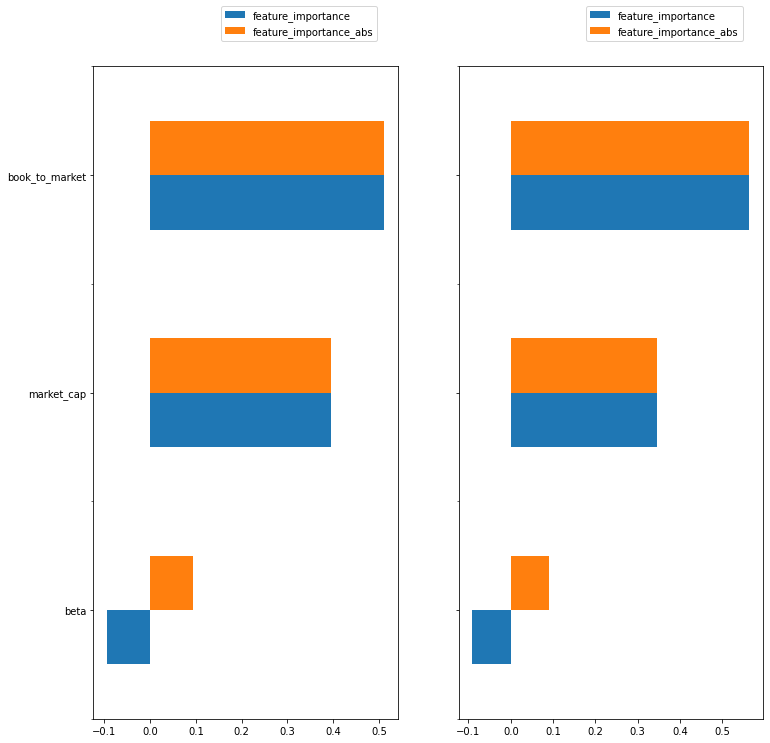

In [ ]:
my_model = best_model
X_train_tensor = tf.Variable(X_train)
X_test_tensor = tf.Variable(X_test)
sum, sum_c = feature_analysis(X_train_tensor, my_model, X_train.columns)
sum_test, sum_c_test = feature_analysis(X_test_tensor, my_model, X_train.columns)

fig,axs = plt.subplots(1,2, figsize=(12,12), sharey= True)

fi_train = pd.DataFrame(sum["feature_importance"])
fi_train.loc[:, "feature_importance_abs"] = fi_train.feature_importance.abs()
fi_train.sort_values(by="feature_importance_abs", ascending=True, inplace =True)
fi_train.plot.barh(ax=axs[0])

fi_test = pd.DataFrame(sum_test["feature_importance"])
fi_test.loc[:, "feature_importance_abs"] = fi_test.feature_importance.abs()
fi_test.sort_values(by="feature_importance_abs", ascending=True, inplace =True)
fi_test.plot.barh(ax=axs[1])

axs[0].legend(bbox_to_anchor=(0.95,1.1))
axs[1].legend(bbox_to_anchor=(0.95,1.1))

display(sum_c)

# Conclusion

In conclusion, based on the results of our 3 models, we can confirm that in this dataset the neural networks have a better performance using the mean absolute error as our evaluation method. It is visualized that the neural network is able to find a different relationship between our features that result in less error. If we take a closer look at our optimized neural network, we see that it uses Tanh as its activation function and this model has the best result out of the 3 trained models in this assignment. This means that there is a non-linear relationship. The linear regression model does not use the beta for calculating the discr_r. When comparing this model to the neural network we can see that beta has a negative impact on the output and uses the 3 available features. Therefore, it can be concluded that the linear regression model does not consider the relationship that beta with either book_to_market or market_cap has or the way that these interact with each other.

